*Ryan Harper*

### Non-NN Stocks Predictor:

**INDICATORS:** <br>
<font color=blue>__HOUST__</font> : Housing Starts: Total: New Privately Owned Housing Units Started <br>
<font color=blue>__UNRATENSA__</font>:Civilian Unemployment Rate NSA<br>
<font color=blue>__EMRATIO__</font>: Civilian Employment-Population Ratio<br>
<font color=blue>__UEMPMED__</font>: Median Duration of Unemployment<br>
<font color=blue>__UMCSENT__</font>: University of Michigan: Consumer Sentiment<br>
<font color=blue>__USSLIND__</font>: Leading Index For United States<br>
<font color=blue>__KCFSI__</font>: Kansas City Financial Stress Index<br>
<font color=blue>__IPMAN__</font></font>: Industrial Production: Manufacturing (NAICS)<br>
<font color=blue>__VIXCLS__</font>: CBOE Volatility Index: NSA<br>
<font color=blue>__DGS10__</font>: 10-Year Treasury Constant Maturity Rate<br>

In [266]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [208]:
# ======== clean csv files ========

# indicators csv (drops blank first row, gets rid of dt indicator columns, sets index to datetime)
indicators = pd.read_csv('Indicators_train.csv').iloc[1:].dropna(how='all')
indicators.date = pd.to_datetime(indicators.date)
for column in indicators:
    if 'dt' in column:
        del indicators[column]
    elif 'date' in column:
        continue
    else:
        indicators[column] = indicators[column].astype(float)
indicators = indicators.set_index(indicators.date)
del indicators['date']

# stock - csv (sets index to datetime)
stock = pd.read_csv('stocks-us-adjClose.csv')
stock.date = pd.to_datetime(stock.date)
stock = stock.set_index(stock.date)
del stock['date']

# sector - csv (loads csv and prints sectors for reference)
sector = pd.read_csv('Company_information.csv', encoding = "ISO-8859-1")
seclist = sector.Sector.unique()
sectorset = []
print('|',end='')
for member in seclist:
    if str(member) != 'nan':
        sectorset.append(member)
        print(member, end='|') 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [211]:
# filters stock dataframe by sector and stores to new sector_dataframe
utilities = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Utilities']['Symbol'].tolist())
basicmaterials = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Basic Materials']['Symbol'].tolist())
consumer = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Consumer Goods']['Symbol'].tolist())
industrial = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Industrial Goods']['Symbol'].tolist())
healthcare = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Healthcare']['Symbol'].tolist())
services = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Services']['Symbol'].tolist())
financial = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Financial']['Symbol'].tolist())
technology = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Technology']['Symbol'].tolist())
conglomerates = pd.DataFrame(data=stock, columns=sector.loc[sector['Sector'] == 'Conglomerates']['Symbol'].tolist())

# Merges sector dataframes with indicators
indic_utilities = pd.merge(utilities,indicators, how='inner', left_index=True, right_index=True).dropna(how='any')
indic_basicmaterials = pd.merge(basicmaterials,indicators, how='inner', left_index=True, right_index=True).dropna(how='any')
indic_health = pd.merge(healthcare,indicators, how='inner', left_index=True, right_index=True).dropna(how='any')

### NOTE: NEED TO DROP DUPLICATE DATES (about 20 of them e.g. 2017-09-05) with '.drop_duplicates(keep='first')'

In [292]:
indic_health.tail()

,LLY,MYL,TMO,BDX,NVO,HUM,THC,VIVO,TFX,TECH,...,HOUST,UNRATENSA,EMRATIO,UEMPMED,UMCSENT,USSLIND,KCFSI,IPMAN,VIXCLS,DGS10
date,,,,,,,,,,,,,,,,,,,,,
2017-09-05,79.820000,31.590000,185.874283,199.336929,46.980000,257.118713,17.690001,13.95,210.940002,121.150002,...,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,10.13,2.12
2017-09-05,79.820000,31.590000,185.874283,199.336929,46.980000,257.118713,17.690001,13.95,210.940002,121.150002,...,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,12.23,2.12
2017-09-06,80.510002,32.240002,189.261627,198.499985,47.840000,256.449860,17.150000,14.05,225.410004,121.660004,...,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,11.63,2.07
2017-09-07,81.540001,31.910000,190.440689,199.570007,48.500000,256.100433,16.950001,13.90,227.139999,120.620003,...,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,11.55,2.10
2017-09-08,82.919998,32.099998,191.479889,203.699997,47.970001,256.130371,16.600000,13.90,232.750000,119.910004,...,1155.0,4.5,60.1,10.5,96.8,1.22,-0.73,104.1579,12.12,2.05


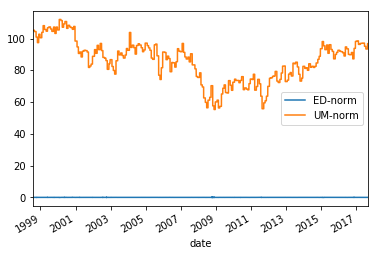

-0.0044340575356823352

In [38]:
# assigning sector db to graph db
graph = indic_utilities[['ED','UMCSENT']].dropna(how='any')

# --- normalizing data - method 1 ---
# graph['ED-norm'] = (graph['ED']-graph['ED'].mean())/graph['ED'].std()
# graph['UM-norm'] = (graph['UMCSENT']-graph['UMCSENT'].mean())/graph['UMCSENT'].std()

# --- normalizing data - method 2 ---
# graph['ED-norm'] = np.log(graph['ED'])
# graph['UM-norm'] = graph['UMCSENT']

# --- normalizing data - method 3 ---
graph['ED-norm'] = graph['ED'].pct_change()
graph['UM-norm'] = graph['UMCSENT']

# displaying data
list = ['ED-norm','UM-norm']
graph.plot(kind='line',y=list)
plt.show()

graph['ED-norm'].corr(graph['UM-norm'])

# graph = indic_utilities[['ED','UNRATENSA']].dropna(how='any').pct_change()
# list = ['ED','UNRATENSA']
# graph.plot(kind='line',y=list)
# plt.show()

# graph['ED'].corr(graph['UNRATENSA'])

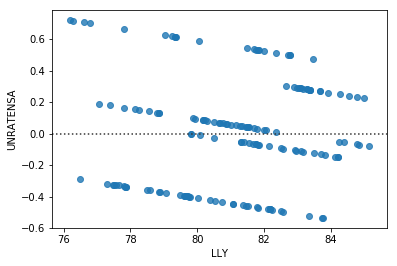

In [298]:
sns.residplot(x='LLY', y='UNRATENSA', data=indic_health[300:])
plt.show()

       nlog      nums
0  0.929321  0.513274
1  0.814709  0.769912
2  0.774956  0.769912
3  0.930981  0.769912
4  0.926707  0.769912


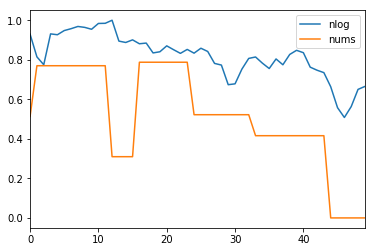

0.70648955023929949

In [263]:
# normalizing the data (indicators are fitted and stocks are: log of each ticker / row is summed / and then summed total is divided by ticker count)
norm_indic = indic_health.copy()
norm_indic['logsum'] = np.log(norm_indic.loc[:, 'LLY':'ADRO']).sum(axis=1)/len(healthcare.columns.tolist())

norm_indic = norm_indic[['logsum','UMCSENT']].dropna(how='any')

# normalizing data
scaler = MinMaxScaler(feature_range=(0,1))
normalized = scaler.fit_transform(norm_indic[['logsum','UMCSENT']])

nlogsum = pd.Series(normalized[:,0])
numcsent = pd.Series(normalized[:,1])
list = [nlogsum,numcsent]

norm_indic['nlogsum'] = nlogsum
norm_indic['nums'] = numcsent
final_norm = pd.concat(list,axis=1)
final_norm.columns = ['nlog','nums']
print(final_norm.head())

final_norm[0:50].plot(kind='line',y=['nlog','nums'])
plt.show()
# graph.plot(kind='line',y=list)
# plt.show()


final_norm['nums'][0:50].corr(final_norm['nlog'])

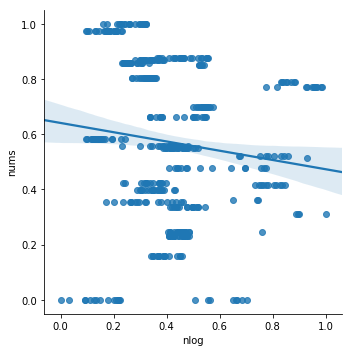

In [291]:
# sns.lmplot(x='index', y=['nums','nlog'], data=final_norm.reset_index())
# plt.show()

sns.lmplot(x='nlog', y='nums', data=final_norm[0:452])
plt.show()

In [265]:
# scipy module linear regression (Doesnt work)


# running regression scipy
x = normalized[:,0]
y = normalized[:,1]

x.tolist()
y.tolist()


slope, intercept, r_value, p_value, std_err = stats.linregress(x[0:50],y[0:50])

print(r_value)
print(p_value)



# running regression scipy
# x = regression['logsum'].tolist()
# y = regression['UNRATENSA'].tolist()

# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# print(r_value)
# print(p_value)

# print(stats.norm(regression['UNRATENSA']))

0.706489550239
9.88716740085e-09


In [201]:
# smf module ols regression (Maybe works?)

logsum_pc = indic_utilities['ED'].pct_change()
# unr_pc = indic_utilities['UNRATENSA'].pct_change()
ols_model = smf.ols('ed_pc ~ unr_pc', ed_pc).fit()
print(ols_model.summary())

graph = indic_utilities[['ED','UMCSENT']].dropna(how='any')

PatsyError: Error evaluating factor: IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
    x ~ y
    ^

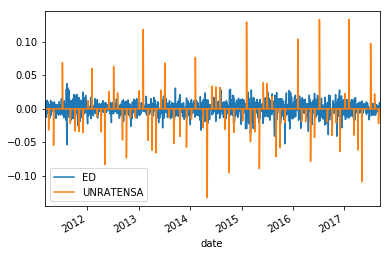

-0.0062404362608488506